## Introduction
Electromyography (EMG) signals capture the electrical activity generated by muscle contractions.
This project focuses on classifying hand gestures using surface EMG signals by extracting meaningful features and training machine learning models. Such systems have applications in prosthetics, rehabilitation, and human–computer interaction.

## Dataset Description

We use the GRABMyo EMG dataset (PhysioNet), which contains:

Multi-channel EMG recordings

32 EMG channels (electrodes)

Multiple hand gestures

Multiple trials per gesture

Each recording corresponds to one gesture trial, sampled at a high frequency.

## Data Loading
EMG data is loaded using the WFDB library from PhysioNet waveform files.


In [1]:
import wfdb
import matplotlib.pyplot as plt

In [2]:
record_path = "../data/grabmyo/Session1/session1_participant1/session1_participant1_gesture1_trial1"
record = wfdb.rdrecord(record_path)
print(record)

In [3]:
record

In [4]:
record.p_signal.shape

(10240, 32)

## Signal Visualization
A representative EMG channel is plotted to observe muscle electrical activity over time.

X-axis: Time samples
Y-axis: EMG amplitude

This plot represents muscle activation over time for a single electrode.

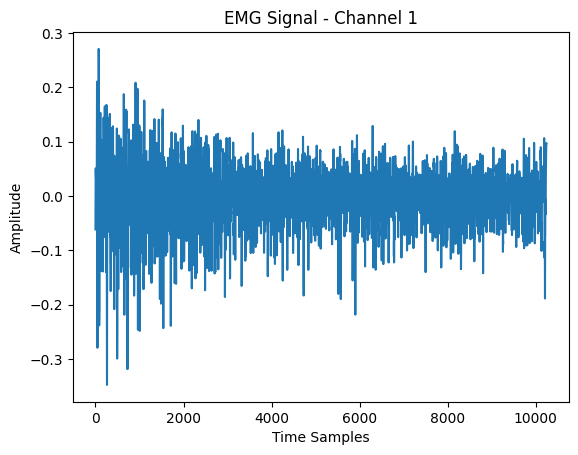

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(record.p_signal[:, 0])
plt.title("EMG Signal - Channel 1")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()


## Preprocessing & Windowing

Raw EMG signals are long and non-stationary.
To make them suitable for machine learning, we divide the signal into fixed-length windows.

Window size: 200 samples

Step size: 200 samples (non-overlapping)

Each window represents a short muscle activity segment.


In [6]:
import numpy as np

signal = record.p_signal #shape (10240,32)

window_size = 200
num_samples = signal.shape[0]   #10240

windows = []

for start in range(0, num_samples - window_size, window_size):  
    window = signal[start:start + window_size, :]
    windows.append(window)

windows = np.array(windows)


In [7]:
print("Windows shape:", windows.shape)  #51 windows , each window = 200 time samples , 32 emg channels

Windows shape: (51, 200, 32)


In [8]:
windows

array([[[-6.15321436e-02, -6.05105048e-02, -7.12050324e-02, ...,
          1.91324042e-02,  2.48906948e-02, -5.12172474e-03],
        [-8.15270236e-03, -1.01173987e-02, -1.48763293e-02, ...,
          2.16451854e-02,  3.72555716e-02, -3.87079383e-03],
        [ 1.62959687e-02,  1.12630972e-02,  1.41530387e-02, ...,
          2.57890702e-02,  4.23597044e-02, -1.44879135e-03],
        ...,
        [-1.57298088e-02, -6.98876061e-03,  1.40357483e-02, ...,
          3.37682526e-02,  6.40085851e-02, -8.21359209e-03],
        [-2.96384700e-02, -2.18475883e-02, -5.44422828e-03, ...,
          1.54230605e-02,  5.12114664e-02, -7.03477296e-03],
        [-4.67836786e-02, -3.98614934e-02, -1.98416219e-02, ...,
         -8.75379915e-04,  3.41149204e-02, -1.08447783e-02]],

       [[-6.13906036e-02, -6.37889650e-02, -3.77675010e-02, ...,
         -1.29795540e-02,  2.05498827e-02, -1.65785593e-02],
        [-6.75523104e-02, -7.93616510e-02, -5.47550571e-02, ...,
         -1.23875705e-02,  1.93083368e

## Feature Extraction

Instead of using raw EMG values, we extract time-domain features from each window:

RMS (Root Mean Square): muscle contraction strength

MAV (Mean Absolute Value): signal intensity

Waveform Length: signal complexity

Zero Crossings: muscle activation frequency

There are 128 features per channel. Each row in the feature matrix represents one window


In [9]:
import numpy as np

def rms(window):
    return np.sqrt(np.mean(window**2, axis=0))

def mav(window):
    return np.mean(np.abs(window), axis=0)

def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)

def zero_crossings(window, threshold=0.01):
    zc = []
    for ch in range(window.shape[1]):
        signal = window[:, ch]
        count = 0
        for i in range(1, len(signal)):
            if ((signal[i-1] > 0 and signal[i] < 0) or 
                (signal[i-1] < 0 and signal[i] > 0)):
                if abs(signal[i] - signal[i-1]) >= threshold:
                    count += 1
        zc.append(count)
    return np.array(zc)


In [10]:
features = []

for w in windows:
    feature_vector = np.concatenate([
        rms(w),
        mav(w),
        waveform_length(w),
        zero_crossings(w)
    ])
    features.append(feature_vector)

features = np.array(features)

print("Final feature matrix shape:", features.shape)


Final feature matrix shape: (51, 128)


In [11]:
features

array([[ 0.10127876,  0.09188076,  0.08681461, ..., 19.        ,
        19.        ,  1.        ],
       [ 0.09591721,  0.09265856,  0.09514797, ..., 25.        ,
        26.        ,  1.        ],
       [ 0.07784523,  0.07679384,  0.08697082, ..., 23.        ,
        20.        ,  0.        ],
       ...,
       [ 0.03939293,  0.04174764,  0.04908477, ..., 15.        ,
        12.        ,  2.        ],
       [ 0.04110935,  0.04638012,  0.05542719, ..., 14.        ,
        12.        ,  0.        ],
       [ 0.0435519 ,  0.04718487,  0.05526151, ..., 12.        ,
        12.        ,  1.        ]], shape=(51, 128))

## Labeling

Each EMG window is assigned a gesture label based on the file name.

Gesture labels are encoded as integers (0–16).

All windows from the same trial share the same gesture label.

In [12]:
gesture_map = {
    "gesture1": 0,
    "gesture2": 1,
    "gesture3": 2,
    "gesture4": 3,
    "gesture5": 4,
    "gesture6": 5,
    "gesture7": 6,
    "gesture8": 7,
    "gesture9": 8,
    "gesture10": 9,
    "gesture11": 10,
    "gesture12": 11,
    "gesture13": 12,
    "gesture14": 13,
    "gesture15": 14,
    "gesture16": 15,
    "gesture17": 16
}


In [13]:
#extracting gesture name from the file name

def get_gesture_label(filename,gesture_map):
    for g in gesture_map:
        if g in filename:
            return gesture_map[g]
        
    raise ValueError("Gesture not found in filename")

In [14]:
#building record list

import os

base_path = '../data/grabmyo/Session1/session1_participant1'

record_list = []

for file in os.listdir(base_path):
    if file.endswith(".hea"):
        record_name = file.replace(".hea", "")
        record_path = os.path.join(base_path, record_name)
        record_list.append((record_path, record_name))

print("Total records found:", len(record_list))
        

Total records found: 119


In [15]:
#windowing function

import numpy as np

def window_signal(signal, window_size=200, step_size=200):
    windows = []
    num_samples = signal.shape[0]

    for start in range(0, num_samples - window_size, step_size):
        window = signal[start:start + window_size, :]
        windows.append(window)

    return np.array(windows)


In [16]:
#feature functions 

def rms(window):
    return np.sqrt(np.mean(window**2, axis=0))

def mav(window):
    return np.mean(np.abs(window), axis=0)

def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)

def zero_crossings(window, threshold=1e-3):
    return np.sum(
        (np.diff(np.sign(window), axis=0) != 0) &
        (np.abs(np.diff(window, axis=0)) > threshold),
        axis=0
    )


In [17]:
# feature extraction wrapper
def extract_features(windows):
    feature_list = []

    for w in windows:
        feature_vector = np.concatenate([
            rms(w),
            mav(w),
            waveform_length(w),
            zero_crossings(w)
        ])
        feature_list.append(feature_vector)

    return np.array(feature_list)


In [18]:
import wfdb

all_features = []
all_labels = []

for record_path, record_name in record_list:
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal

    windows = window_signal(signal)
    features = extract_features(windows)

    label = get_gesture_label(record_name, gesture_map)
    labels = np.full(len(features), label)

    all_features.append(features)
    all_labels.append(labels)

X = np.vstack(all_features)
y = np.concatenate(all_labels)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6069, 128)
y shape: (6069,)


In [19]:
X  #contains feature values extracted from each EMG window

array([[8.54852084e-02, 1.14878569e-01, 1.46935777e-01, ...,
        2.80000000e+01, 2.50000000e+01, 4.90000000e+01],
       [9.26000101e-02, 1.23069957e-01, 1.64249776e-01, ...,
        4.00000000e+01, 2.40000000e+01, 4.20000000e+01],
       [6.90466844e-02, 1.01273822e-01, 1.41089220e-01, ...,
        3.30000000e+01, 2.20000000e+01, 4.70000000e+01],
       ...,
       [2.25250280e-02, 2.77471620e-02, 3.31086004e-02, ...,
        2.90000000e+01, 2.70000000e+01, 7.00000000e+01],
       [2.30596841e-02, 3.36848305e-02, 3.90472880e-02, ...,
        3.90000000e+01, 3.60000000e+01, 5.70000000e+01],
       [2.26824274e-02, 2.69101022e-02, 2.87453229e-02, ...,
        1.80000000e+01, 2.40000000e+01, 5.70000000e+01]],
      shape=(6069, 128))

In [20]:
y #respresents the integer encoded gesture label associated with each window

array([0, 0, 0, ..., 8, 8, 8], shape=(6069,))

## Train-Test Split and Scaling
The dataset is split into training and testing sets to evaluate model generalization.

Feature scaling is applied using StandardScaler:

Mean = 0

Standard deviation = 1

Only training data is used to fit the scaler to avoid data leakage.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#1 train test split

X_train,X_test,y_train,y_test= train_test_split (X,y,test_size=0.2,random_state=42,stratify=y)

#2 scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [22]:
print(X_train_scaled)
print(X_test_scaled)

[[-0.12041295  0.55111321  0.70270192 ... -0.19010462 -1.16074548
   0.23128004]
 [-0.19703278 -0.34184072 -0.47590094 ...  2.88642175  2.67694575
   1.02482391]
 [-0.4783721  -0.63004088 -0.63730997 ...  0.13374026  0.06731571
  -0.56226383]
 ...
 [-0.39501503 -0.26833589 -0.13180195 ... -0.83779438 -0.23969959
   1.18353268]
 [-0.10977245 -0.35289317 -0.46599663 ... -1.3235617   0.06731571
   0.07257126]
 [-0.30714777  0.0887961   0.3525851  ... -0.19010462  0.83485396
   0.54869758]]
[[-0.64280583 -0.8008602  -0.78224678 ...  0.13374026 -0.39320723
   0.38998881]
 [-0.28966396 -0.44372062 -0.60653333 ... -0.19010462  1.9094075
   0.38998881]
 [-0.35640344 -0.49923723 -0.53324499 ...  0.94335247  0.22082336
  -1.51451648]
 ...
 [-0.94126662 -1.09183728 -1.07378937 ... -0.99971682 -0.23969959
  -1.51451648]
 [ 1.07431729  0.73365661  0.49080448 ...  0.94335247 -0.39320723
  -0.87968138]
 [-0.5615828  -0.62183524 -0.43635954 ...  1.91488711  3.29097635
  -0.72097261]]


## Exploratory Data Analysis (EDA)

Before training the machine learning model, exploratory data analysis was performed to better understand the characteristics of the extracted EMG features. Visualizing feature distributions helps verify correct feature extraction, scaling, and variability across EMG windows.


### Feature Distribution Visualization

The histogram above shows the distribution of the Root Mean Square (RMS) feature extracted from the first EMG channel across all training windows. RMS represents the muscle activation intensity within a window.

After standardization, the feature values are centered around zero with unit variance, indicating successful feature scaling. Such visualizations help ensure that no feature dominates the learning process due to scale differences.


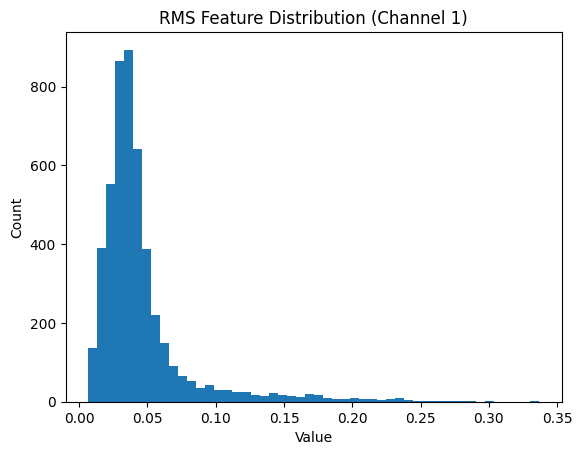

In [23]:
import matplotlib.pyplot as plt

plt.hist(X_train[:, 0], bins=50)
plt.title("RMS Feature Distribution (Channel 1)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


### Effect of Feature Scaling

The left plot shows the distribution of the RMS feature before scaling, while the right plot shows the same feature after standardization. Feature scaling ensures that all extracted EMG features contribute equally during model training and prevents features with larger numeric ranges from dominating the classifier.


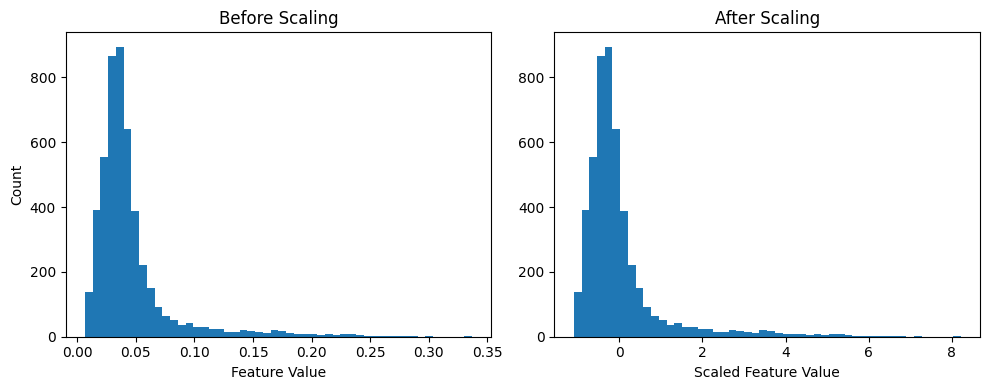

In [24]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(X_train[:, 0], bins=50)
plt.title("Before Scaling")
plt.xlabel("Feature Value")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(X_train_scaled[:, 0], bins=50)
plt.title("After Scaling")
plt.xlabel("Scaled Feature Value")

plt.tight_layout()
plt.show()


### Gesture Class Distribution

The bar chart above illustrates the distribution of EMG windows across different gesture classes in the training dataset. A relatively balanced class distribution ensures that the classifier does not become biased toward any specific gesture during training.


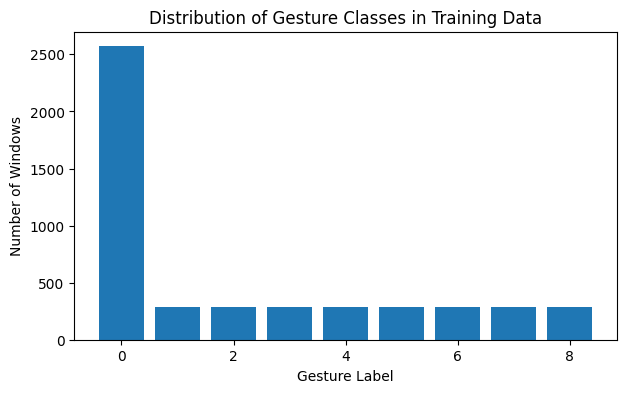

In [25]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(7,4))
plt.bar(unique, counts)
plt.xlabel("Gesture Label")
plt.ylabel("Number of Windows")
plt.title("Distribution of Gesture Classes in Training Data")
plt.show()


## Model Training 
Four models are trained. 


### Logistic Regression

Logistic Regression is a linear classification model that estimates the probability of a sample belonging to a particular class. Although simple, it provides an important baseline for understanding whether the extracted EMG features are linearly separable. The model was trained using standardized feature values and optimized using a maximum iteration limit of 1000.

Test accuracy: 94.72%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test_scaled)

# Accuracy
lr_acc = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", lr_acc)


Logistic Regression Accuracy: 0.9472817133443163


### k-Nearest Neighbors (kNN)

k-Nearest Neighbors is a distance-based classification algorithm that assigns a class label to a test sample based on the majority label of its k closest neighbors in the feature space. In this study, kNN serves as a simple baseline model to evaluate how well the extracted EMG features separate different hand gestures. The Euclidean distance metric was used, and the number of neighbors was set to k = 5.

Test accuracy: 77.92%

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# kNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X_train_scaled, y_train)

# Predict
y_pred_knn = knn.predict(X_test_scaled)

# Accuracy
knn_acc = accuracy_score(y_test, y_pred_knn)
print("kNN Accuracy:", knn_acc)


kNN Accuracy: 0.7792421746293245



### SVM Classifier 
A Support Vector Machine (SVM) classifier was used as the primary model for EMG-based hand gesture recognition. SVMs are supervised learning models that aim to find an optimal hyperplane that maximizes the margin between different gesture classes in the feature space.

Test Accuracy: 94.15%

In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#SVM Model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')

#Train
svm_model.fit(X_train_scaled, y_train)

#Predict
y_pred_svm = svm_model.predict(X_test_scaled)

#Accuracy
svm_acc = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_acc)


SVM Accuracy: 0.9415156507413509


### Random Forest Classifier


A Random Forest classifier was trained as a baseline ensemble learning method. Random Forests operate by constructing multiple decision trees during training and aggregating their predictions, which helps reduce overfitting and improve generalization compared to a single decision tree.

Test Accuracy: 91.35%

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#RF Model
rf = RandomForestClassifier(n_estimators=200, random_state=42)

#Train
rf.fit(X_train, y_train)   # scaling not required

#Predict
y_pred_rf = rf.predict(X_test)

#Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.913509060955519


## Confusion matrix for logistic regression
The confusion matrix is used to evaluate the performance of the Logistic Regression classifier by comparing the true labels with the predicted labels on the test dataset.

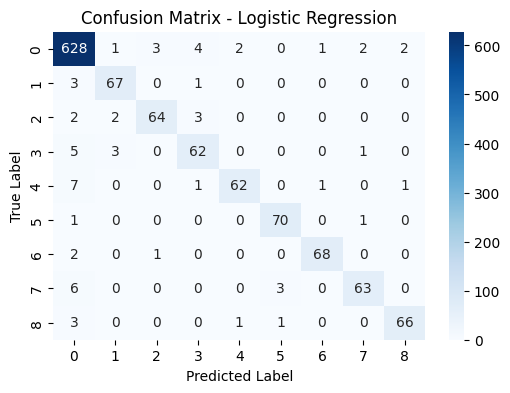

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()





In [44]:
cm  #confusion matrix

array([[628,   1,   3,   4,   2,   0,   1,   2,   2],
       [  3,  67,   0,   1,   0,   0,   0,   0,   0],
       [  2,   2,  64,   3,   0,   0,   0,   0,   0],
       [  5,   3,   0,  62,   0,   0,   0,   1,   0],
       [  7,   0,   0,   1,  62,   0,   1,   0,   1],
       [  1,   0,   0,   0,   0,  70,   0,   1,   0],
       [  2,   0,   1,   0,   0,   0,  68,   0,   0],
       [  6,   0,   0,   0,   0,   3,   0,  63,   0],
       [  3,   0,   0,   0,   1,   1,   0,   0,  66]])

In [45]:
np.unique(y_test)


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Model Evaluation - Logistic Regression (Classification report)
The classification report provides a detailed evaluation of the Logistic Regression model by reporting precision, recall, F1-score, and support for each class.

In [ ]:
#model evaluation of logistic regression
from sklearn.metrics import classification_report   

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       643
           1       0.92      0.94      0.93        71
           2       0.94      0.90      0.92        71
           3       0.87      0.87      0.87        71
           4       0.95      0.86      0.91        72
           5       0.95      0.97      0.96        72
           6       0.97      0.96      0.96        71
           7       0.94      0.88      0.91        72
           8       0.96      0.93      0.94        71

    accuracy                           0.95      1214
   macro avg       0.94      0.92      0.93      1214
weighted avg       0.95      0.95      0.95      1214



## Cross-Validation Results – Logistic Regression

To evaluate the robustness and generalization capability of the Logistic Regression model, 5-fold cross-validation was performed on the training dataset.

Cross-Validation Accuracies

Fold 1: 0.9310

Fold 2: 0.9351

Fold 3: 0.9413

Fold 4: 0.9320

Fold 5: 0.9372

Summary Statistics

Mean Cross-Validation Accuracy: 0.9353 (93.53%)

Standard Deviation: 0.0037 (0.37%)

In [60]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    log_reg,              # Logistic Regression model
    X_train_scaled,       # TRAINING data only
    y_train,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy'
)

print("Cross-validation accuracies:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())


Cross-validation accuracies: [0.93099897 0.93511843 0.94129763 0.93202884 0.93717817]
Mean CV accuracy: 0.9353244078269825
Standard deviation: 0.003707518022657075


## Model Accuracy Comparison Table

In [59]:
import pandas as pd

# Store model accuracies
results = {
    "Model": [
        "Logistic Regression",
        "k-Nearest Neighbors",
        "Support Vector Machine",
        "Random Forest"
    ],
    "Accuracy": [
        lr_acc,
        knn_acc,
        svm_acc,
        rf_acc
    ]
}

# Create DataFrame
results_df = pd.DataFrame(results)

# Display table
print(results_df)


                    Model  Accuracy
0     Logistic Regression  0.947282
1     k-Nearest Neighbors  0.779242
2  Support Vector Machine  0.941516
3           Random Forest  0.913509


## PCA of EMG Features

After extracting time-domain features (RMS, MAV, Waveform Length, and Zero Crossings) from the EMG signals, the resulting feature vectors are 128-dimensional.
To better understand the structure of this high-dimensional feature space, Principal Component Analysis (PCA) was applied for visualization.

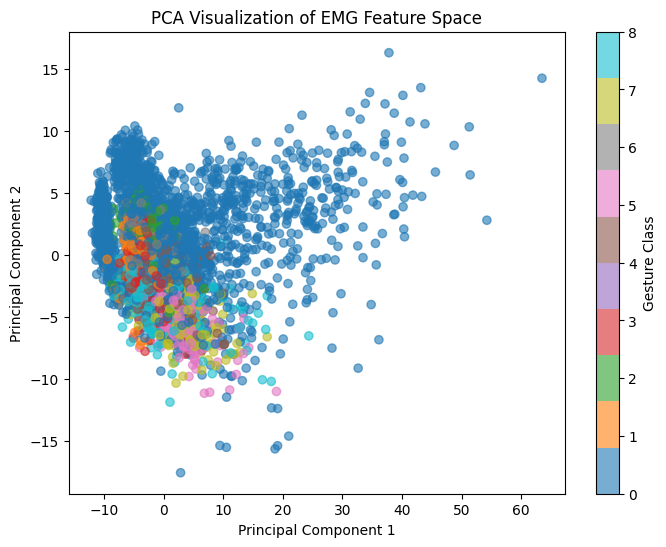

Total variance explained: 0.6067402884171132


In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train,
    cmap='tab10',
    alpha=0.6
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of EMG Feature Space")
plt.colorbar(scatter, label="Gesture Class")
plt.show()

print("Total variance explained:", pca.explained_variance_ratio_.sum())



The strong performance of linear models is consistent with the PCA visualization, which indicates reasonable class separability in the reduced feature space.

## Conclusion

This study evaluated multiple machine learning models for EMG-based hand gesture classification using a subset of the GrabMyo dataset (Session 1, Participant 1). Among the evaluated classifiers, Logistic Regression achieved the highest accuracy (94.73%) and was selected as the baseline model for detailed analysis.

The model demonstrated stable and reliable performance, as confirmed by 5-fold cross-validation with a mean accuracy of 93.53% and low variance. PCA visualization further supported these results by revealing reasonable class separability in the EMG feature space.

Overall, the results indicate that simple and interpretable models can effectively classify EMG signals in a controlled single-subject setting.

## Future Work

Deep learning models (CNN/LSTM) on raw EMG

Subject-independent evaluation

Real-time gesture recognition

Feature selection and optimization